In [102]:
%ls

sample_data/


In [63]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


In [66]:
# Local path variables
# from datapath import data_path, zip_path

# Colab path variables
zip_path = "sample_data/dogs-vs-cats.zip"
data_path = "sample_data"

In [67]:
zip_train_path = os.path.join(data_path,"train.zip")
zip_test_path = os.path.join(data_path,"test1.zip")


In [68]:
# Extract the image directories from the zip files
zip_outer = zipfile.ZipFile(zip_path,'r')
zip_outer.extractall(data_path)
zip_outer.close()

zip_train = zipfile.ZipFile(zip_train_path)
zip_train.extractall(data_path)
zip_train.close()

zip_test = zipfile.ZipFile(zip_test_path)
zip_test.extractall(data_path)
zip_test.close()

del zip_outer, zip_train, zip_test

# delete zip files to reclaim space
os.remove(f"{data_path}/train.zip")
os.remove(f"{data_path}/test1.zip")
# os.remove(zip_path)

In [69]:
def move_image(source,destination,image_name):
     shutil.move(os.path.join(source,image_name),
                 os.path.join(destination,image_name),
                 copy_function=copyfile)
    

In [70]:
def sort_images(source_path,cat_path,dog_path,index_limit):
    for index,fname in enumerate(os.listdir(source_path)):
        if index < index_limit:
            move_image(source_path,cat_path,fname)
        else:
            move_image(source_path,dog_path,fname)
    
    shutil.rmtree(source_path)

In [71]:
# filter files into the correct directories, and split portion of random files from the training data into a validation set

def filter_images(source, training, testing, split_size):
    
    dir_source = os.listdir(source)
    
    def choose_random(source, split_size):
        source_range = range(0, int(len(dir_source)))
        training_size = int(split_size * len(dir_source))
        training_index = random.sample(source_range,k=training_size)
        
        return training_index
    
    def copy_images(source,training,testing,random_index):
        for index,fname in enumerate(os.listdir(source)):
            if index in random_index:
                move_image(source,training,fname)
            else:
                move_image(source,testing,fname)
    
    random_index = choose_random(source,split_size)
    copy_images(source, training, testing, random_index)
    
    shutil.rmtree(source)
    

In [72]:
# initialize variables for training and validation directory paths
dir_toplevel = os.path.join(data_path,"dogs-vs-cats")
dir_training = os.path.join(dir_toplevel,'training')
dir_training_cats = os.path.join(dir_training,'cats')
dir_training_dogs = os.path.join(dir_training,'dogs')

dir_validation = os.path.join(dir_toplevel,'validation')
dir_validation_cats = os.path.join(dir_validation, 'cats')
dir_validation_dogs = os.path.join(dir_validation, 'dogs')

dir_test = os.path.join(dir_toplevel,"test")

# create directories for training and validation
tmp_train = os.path.join(data_path,"train")
tmp_cats = os.path.join(data_path,"cats")
tmp_dogs = os.path.join(data_path,"dogs")
tmp_test = os.path.join(data_path,"test1")

In [73]:
dir_training

'sample_data/dogs-vs-cats/training'

In [74]:
# Create directories to hold filtered training and vaidation sets
os.mkdir(dir_toplevel)
os.mkdir(dir_training)
os.mkdir(dir_training_cats)
os.mkdir(dir_training_dogs)
os.mkdir(dir_validation)
os.mkdir(dir_validation_cats)
os.mkdir(dir_validation_dogs)
os.mkdir(tmp_cats)
os.mkdir(tmp_dogs)
os.mkdir(dir_test)

In [75]:
# sort labeled cat and dog images into separate folders, and move test data to new location
sort_images(tmp_train,tmp_cats,tmp_dogs,12500)
sort_images(tmp_test,dir_test,dir_test,12500)
move_image(data_path,dir_toplevel,"sampleSubmission.csv")

# randomly sample the images, and create separate training an validation sets
# percent of the images to be used for training is set by the split_size
split_size = 0.9

filter_images(tmp_cats,dir_training_cats,dir_validation_cats,split_size)
filter_images(tmp_dogs,dir_training_dogs,dir_validation_dogs,split_size)

#remove empty directory tree
#shutil.rmtree(data_path)

In [81]:
len(os.listdir(dir_training_cats))

11250

In [100]:
# Configure tensorflow to generate training data from image directory, and normalize the image data
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(dir_training,
                                                   batch_size = 20,
                                                   class_mode='binary',
                                                   target_size=(150,150))

# Configure tensorflow to generate validation data from image directory, and normalize the image data
validation_datagen = ImageDataGenerator(rescale=1.0/255) 
validation_generator = validation_datagen.flow_from_directory(dir_validation,
                                                             batch_size = 20,
                                                             class_mode='binary',
                                                             target_size=(150,150))

In [103]:
#Keras model for image classification
model = tf.keras.models.Sequential([
    # Alternating convolution and pooling layers to process the images before analysis
    # The convulation layers accent features from the images,
    # The pooling layers reduce the amount of information to process
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the images for analysis by the nn
    tf.keras.layers.Flatten(),
    # Neural network for image classification 256 neuron hidden layer, with a 1 nueron output layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [104]:
history = model.fit(train_generator,
                      epochs=10,
                      steps_per_epoch=1125,
                      validation_steps=125,
                      verbose=2,
                      validation_data=validation_generator)

Epoch 1/10
1125/1125 - 192s - loss: 0.6938 - acc: 0.5017 - val_loss: 0.6961 - val_acc: 0.5000
Epoch 2/10
1125/1125 - 192s - loss: 0.6934 - acc: 0.5017 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/10
1125/1125 - 194s - loss: 0.6934 - acc: 0.4982 - val_loss: 0.6932 - val_acc: 0.5008
Epoch 4/10
1125/1125 - 192s - loss: 0.6933 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5004
Epoch 5/10
1125/1125 - 192s - loss: 0.6934 - acc: 0.5014 - val_loss: 0.6932 - val_acc: 0.4960
Epoch 6/10
1125/1125 - 192s - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6933 - val_acc: 0.5012
Epoch 7/10
1125/1125 - 192s - loss: 0.6933 - acc: 0.4958 - val_loss: 0.6932 - val_acc: 0.5008
Epoch 8/10
1125/1125 - 190s - loss: 0.6933 - acc: 0.4965 - val_loss: 0.6938 - val_acc: 0.4880
Epoch 9/10


KeyboardInterrupt: ignored

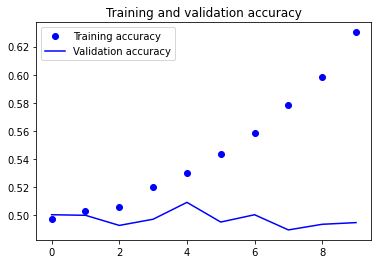

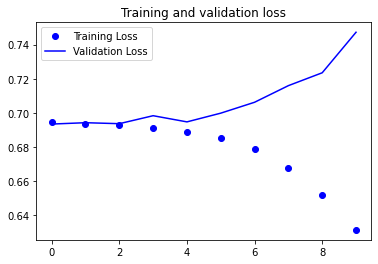

In [105]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
